# **Clustering - Grupo 03**

## **Authors**

- César López Mantecón - 100472092
- Manuel Gómez-Plana Rodríguez - 100472310



## **Repositorio**

Esta práctica se ha llevado a cabo en este [repositorio de github](https://github.com/ManuGPR/AA_P2_G03.git)

## **Introducción**

En este cuaderno se resolverá un problema de clustering usando un dataset de estrellas.

# **Carga de dataset**

## **Carga del dataset por drive**

In [13]:
# Para ejecutar el cuaderno en drive
from google.colab import drive
import pandas as pd

drive.mount('/content/drive')
stars = pd.read_csv("/content/drive/MyDrive/stars_data.csv") # acceder al csv en drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Carga del dataset en local**

In [14]:
import pandas as pd
stars = pd.read_csv("starts_data.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'starts_data.csv'

# **1. Descripción del dataset**
Como podemos ver en la salida del código, contamos con un dataset de 240 instancias y 6 características. De estas 6 características, 4 son numéricas y 2 son categóricas.

In [15]:
stars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Temperature     240 non-null    int64  
 1   L               240 non-null    float64
 2   R               240 non-null    float64
 3   A_M             240 non-null    float64
 4   Color           240 non-null    object 
 5   Spectral_Class  240 non-null    object 
dtypes: float64(3), int64(1), object(2)
memory usage: 11.4+ KB


# **2. K-Means**
En este apartado, se cubre una implementación propia del algoritmo K-Means, el cuál compararemos luego con el algoritmo de `scikit-learn`.

## **2.1. MyK_Means**
Primero, debemos realizar una implementación propia del K-Means, la cual llamaremos MyK_Means.

iteraciones:  6


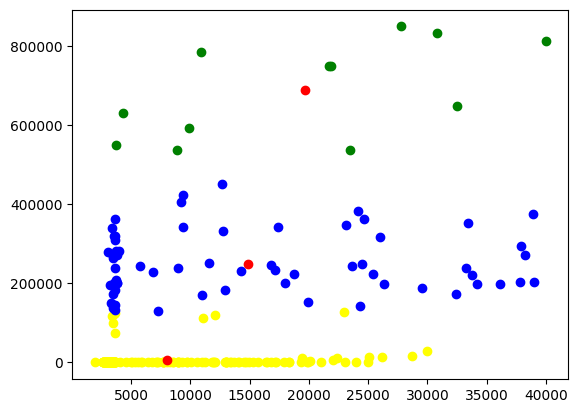

In [4]:
from random import random
from math import sqrt
import matplotlib.pyplot as plt
import numpy

class MyK_Means:
  def __init__(self, k: int, data: pd.DataFrame):
    # Número de clusters
    self.k = k

    # Datos sobre los que trabajar
    self.data = data

    # Lista con centroides, index del centroide = value del centroide
    self.centroids = []

    # Lista con los clusters, index del centroide = lista con instancias de esos clusters
    self.past_clusters = []
    self.clusters = []

    self.init_cluster()
    self.init_centroid()

  def init_cluster(self):
    for key in range(self.k):
      self.clusters.append(pd.DataFrame(columns=self.data.columns))

  def init_centroid(self):
    list_min = self.data.min().to_list()
    list_max = self.data.max().to_list()

    for key in range(self.k):
      centroid_list = []
      for column in range(len(self.data.columns)):
        centroid_list.append(random()*(list_max[column] - list_min[column]) + list_min[column])
      self.centroids.append(tuple(centroid_list))

  def calculate_closest_centroid(self, row):
    distances_cluster = []
    for key in range(len(self.centroids)):
      distances_cluster.append((self.calc_distance(self.centroids[key], row)))
    return distances_cluster.index(min(distances_cluster))

  def fit(self):
    it = 0
    while (True):
      it += 1
      self.past_clusters = []
      for n in range (self.k):
        self.past_clusters.append(self.clusters[n].copy(deep=True))
      self.clusters = []
      self.init_cluster()
      for row in range(len(self.data)):
        closest_centroid = self.calculate_closest_centroid(self.data.iloc[row, :])
        self.clusters[closest_centroid].loc[len(self.clusters[closest_centroid])] = self.data.iloc[row, :]
      self.recalculate_centroids()

      if (self.check_variation()):
        return it



  @staticmethod
  def calc_distance(vec1, vec2):
    return numpy.linalg.norm(vec1-vec2)

  def recalculate_centroids(self):
    self.centroids = []
    for index in range(len(self.clusters)):
      self.centroids.append(self.clusters[index].mean())

  def check_variation(self):
    for i in range(self.k):
      if not self.clusters[i].equals(self.past_clusters[i]):
        return False
    return True





a = MyK_Means(3, stars.iloc[0:, 0:2])
print("iteraciones: ", a.fit())

plt.scatter(a.clusters[0].iloc[0: , 0], a.clusters[0].iloc[0:, 1], color="yellow", label="datos")
plt.scatter(a.clusters[1].iloc[0: , 0], a.clusters[1].iloc[0:, 1], color="blue", label="datos")
plt.scatter(a.clusters[2].iloc[0: , 0], a.clusters[2].iloc[0:, 1], color="green", label="datos")

plt.scatter(*zip(*a.centroids), color="red", label="destacados")
plt.show()

## **2.2. PCA**
**PROBABLEMENTE HAYA QUE MOVERLO DEBAJO PARA PODER HACER EL PCA CON VARIABLES CATEGÓRICAS TRANsFORMADAS.**

Para poder realizar correctamente la comparación entre nuestro K_Means y el K_means implementado de `scikit-learn`, primero deberemos aplicar una reducción de dimensionalidad sobre el data-set. Para ello, usaremos PCA.

In [5]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
stars = pca.fit_transform(stars)

ValueError: could not convert string to float: 'Red'

## **2.3. Comparación**
**PROBABLEMENTE HAYA QUE MOVERLO DEBAJO PARA PODER HACER EL PCA CON VARIABLES CATEGÓRICAS TRANSFORMADAS Y LUEGO COMPARARLOS.**

Tras aplicar la transformación de datos, compararemos las implementaciones. Para poder compararlos justamente, es necesario que cuenten ambos con el mismo número de clusters.

In [6]:
from sklearn.cluster import KMeans
import MyK_Means

kmeans = KMeans(n_clusters=3)
my_kmeans = MyK_Means(3)

ModuleNotFoundError: No module named 'MyK_Means'

# **3. Conversión de variables categóricas**
En este apartado se muestran dos maneras de transformar las variables categóricas a variables numéricas. Empezaremos por one-hot encoding, y luego seguiremos con una codificación ordinal.

## **3.1. One-Hot Encoding**
La primera manera es hacer un One-Hot Encoding, que es parecido a una transformación a un mapa de bits.

In [30]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Crea el preprocesador
cat_transformer = Pipeline(
  steps= [
    ('onehot', OneHotEncoder())
  ])

# Se crea el transformador
preprocessor = ColumnTransformer(
    transformers = [
      ('cat', cat_transformer, ["Color","Spectral_Class"]),
    ],
    remainder = 'passthrough')
onehot_stars = preprocessor.fit_transform(stars)

# Se consiguen los nombres de las columnas
cat_columns_names = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(input_features=["Color", "Spectral_Class"])
all_columns_names = list(cat_columns_names) + ["Temperature", "L", "R", "A_M"]

# Se consigue el dataframe transformado
onehot_df = pd.DataFrame(onehot_stars.toarray(), columns=all_columns_names)
onehot_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 28 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Color_Blue                240 non-null    float64
 1   Color_Blue White          240 non-null    float64
 2   Color_Blue white          240 non-null    float64
 3   Color_Blue-White          240 non-null    float64
 4   Color_Blue-white          240 non-null    float64
 5   Color_Orange              240 non-null    float64
 6   Color_Orange-Red          240 non-null    float64
 7   Color_Pale yellow orange  240 non-null    float64
 8   Color_Red                 240 non-null    float64
 9   Color_White               240 non-null    float64
 10  Color_White-Yellow        240 non-null    float64
 11  Color_Whitish             240 non-null    float64
 12  Color_Yellowish           240 non-null    float64
 13  Color_Yellowish White     240 non-null    float64
 14  Color_whit

## **3.2. Codificación ordinal**